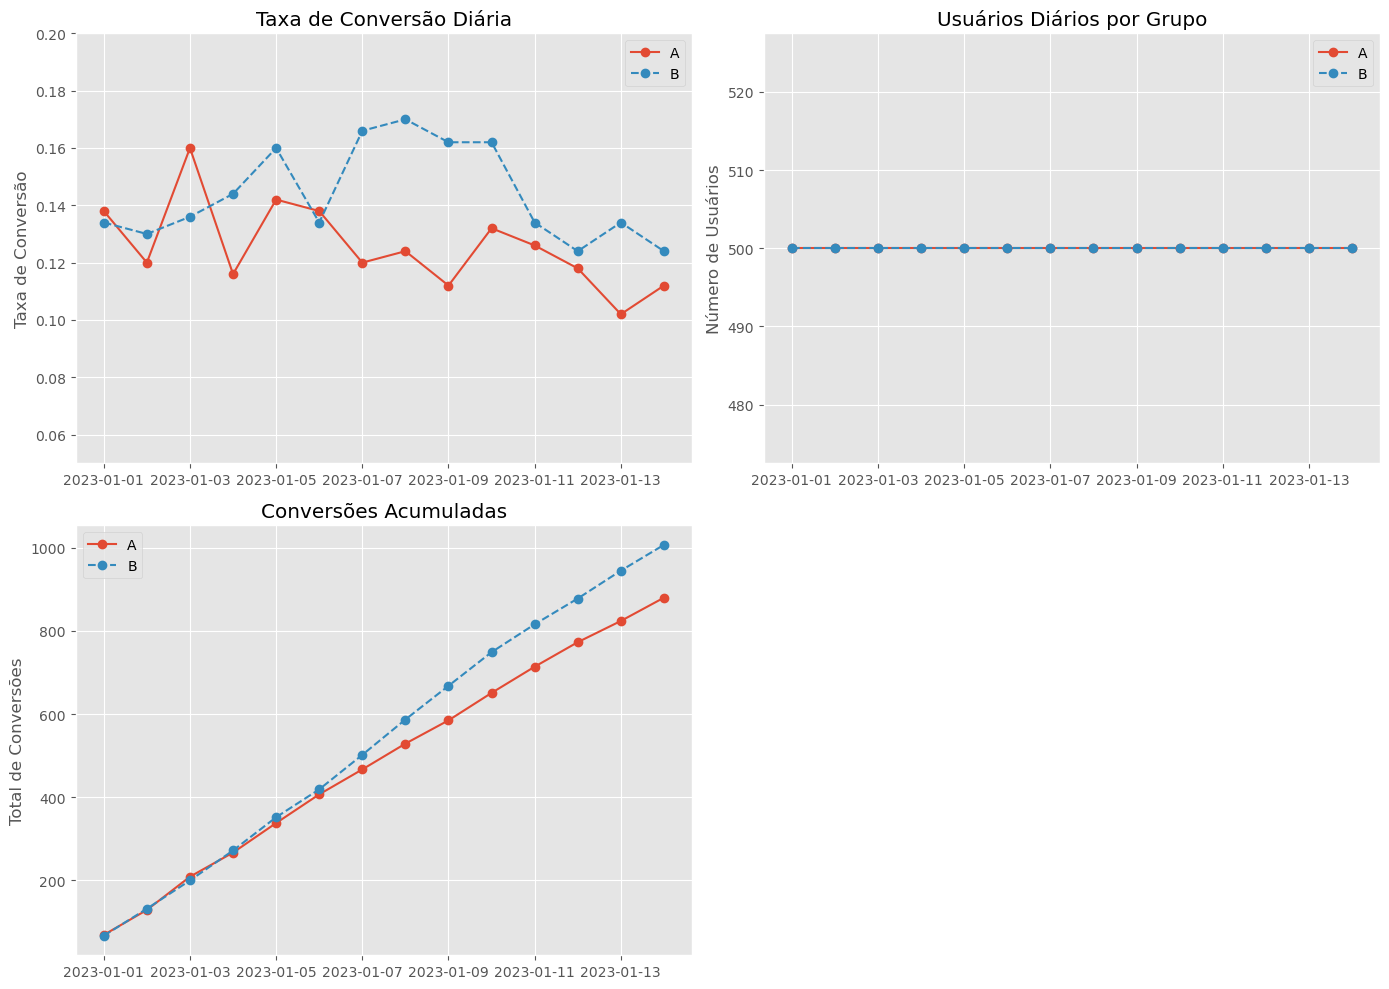

c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\t

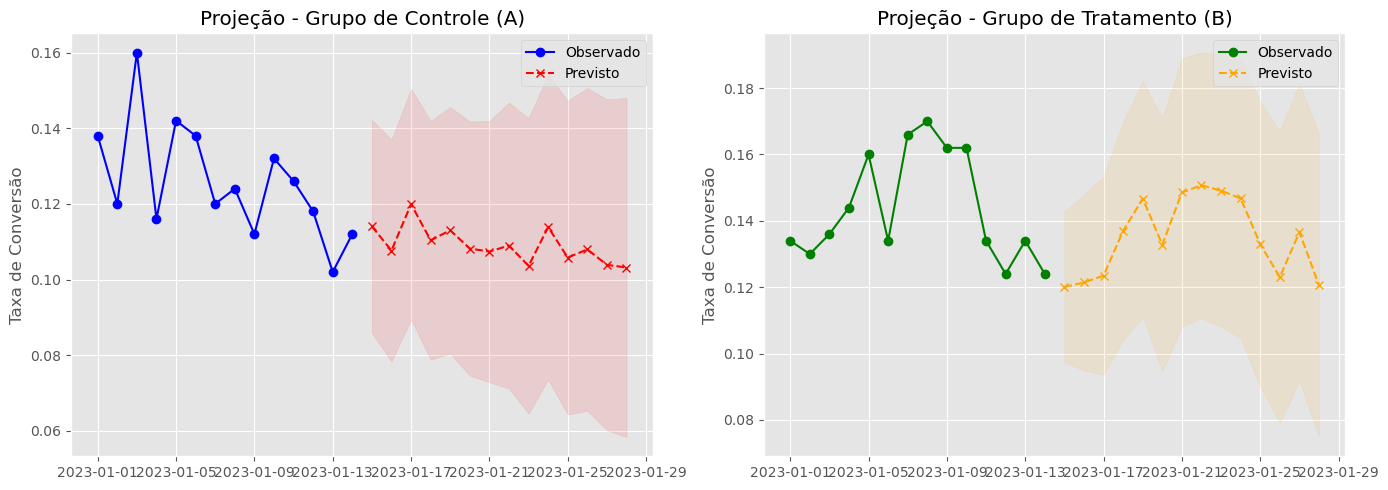

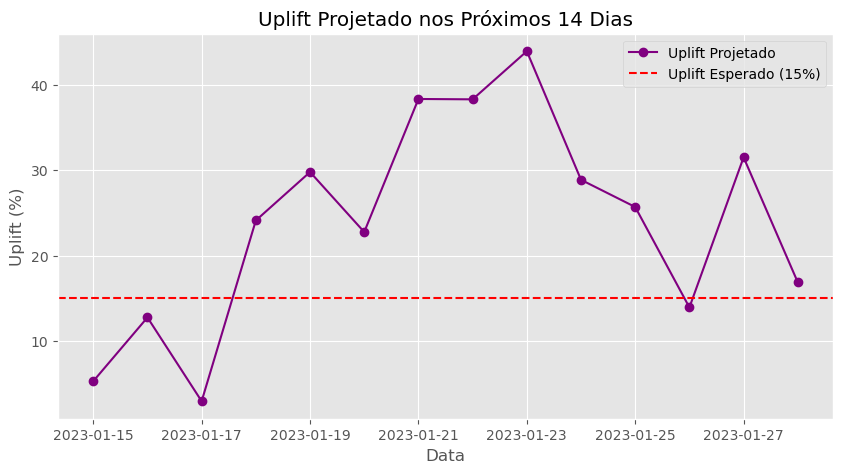


Resumo do Uplift Projetado:
Média: 23.95%
Mínimo: 2.98%
Máximo: 43.93%
Desvio Padrão: 11.93%


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import bernoulli
from datetime import datetime, timedelta

# Configurações iniciais
np.random.seed(42)
plt.style.use('ggplot')

## 1. Gerar dados sintéticos para o teste A/B (14 dias)
n_users_per_group = 500
n_days = 14
dates = pd.date_range(start="2023-01-01", periods=n_days)

# Função para gerar dados de um grupo
def generate_group_data(group_name, base_conversion, uplift=1.0, n_days=n_days, n_users=n_users_per_group):
    data = []
    for day in range(n_days):
        # Efeito temporal: conversão oscila levemente ao longo do tempo
        daily_effect = 0.02 * np.sin(day/3)
        true_conversion = base_conversion * uplift + daily_effect
        
        conversions = bernoulli.rvs(true_conversion, size=n_users)
        for user_id, conv in enumerate(conversions):
            data.append({
                'date': dates[day],
                'group': group_name,
                'user_id': f"{group_name}_{day}_{user_id}",
                'converted': conv
            })
    return data

# Gerar dados para controle (A) e tratamento (B)
control_data = generate_group_data('A', base_conversion=0.12)
treatment_data = generate_group_data('B', base_conversion=0.12, uplift=1.15)  # 15% de uplift

# Combinar os dados
df = pd.DataFrame(control_data + treatment_data)

# Agregar dados diários para visualização
daily_stats = df.groupby(['date', 'group'])['converted'].agg(['mean', 'count', 'sum']).reset_index()
daily_stats.rename(columns={'mean': 'conversion_rate', 'count': 'users', 'sum': 'conversions'}, inplace=True)

## 2. Visualizar as métricas ao longo do tempo (sem Seaborn)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico de Taxa de Conversão Diária
for group in ['A', 'B']:
    group_data = daily_stats[daily_stats['group'] == group]
    axes[0, 0].plot(group_data['date'], group_data['conversion_rate'], 
                   marker='o', label=group, 
                   linestyle='-' if group == 'A' else '--')
axes[0, 0].set_title('Taxa de Conversão Diária')
axes[0, 0].set_ylabel('Taxa de Conversão')
axes[0, 0].set_ylim(0.05, 0.2)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Gráfico de Usuários Diários
for group in ['A', 'B']:
    group_data = daily_stats[daily_stats['group'] == group]
    axes[0, 1].plot(group_data['date'], group_data['users'], 
                   marker='o', label=group,
                   linestyle='-' if group == 'A' else '--')
axes[0, 1].set_title('Usuários Diários por Grupo')
axes[0, 1].set_ylabel('Número de Usuários')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Gráfico de Conversões Acumuladas
cumulative = df.groupby(['group', 'date'])['converted'].sum().groupby('group').cumsum().reset_index()
for group in ['A', 'B']:
    group_data = cumulative[cumulative['group'] == group]
    axes[1, 0].plot(group_data['date'], group_data['converted'], 
                   marker='o', label=group,
                   linestyle='-' if group == 'A' else '--')
axes[1, 0].set_title('Conversões Acumuladas')
axes[1, 0].set_ylabel('Total de Conversões')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Remover o quarto gráfico (subplot vazio)
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

## 3. Modelagem e Projeção Futura

# Função para modelar e projetar (usando SARIMA ou ARIMA como fallback)
def forecast_conversion_rate(series, days_to_forecast=14):
    ts = series.set_index('date')['conversion_rate']
    
    try:
        # Tentar SARIMA com sazonalidade semanal
        model = SARIMAX(ts, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
        model_fit = model.fit(disp=False)
    except:
        # Fallback para ARIMA simples
        model = ARIMA(ts, order=(1, 0, 1))
        model_fit = model.fit()
    
    # Fazer previsão
    forecast = model_fit.get_forecast(steps=days_to_forecast)
    forecast_df = forecast.conf_int()
    forecast_df['forecast'] = forecast.predicted_mean
    forecast_df.index.name = 'date'
    
    return ts, forecast_df

# Aplicar para cada grupo
control_series = daily_stats[daily_stats['group'] == 'A'].copy()
treatment_series = daily_stats[daily_stats['group'] == 'B'].copy()

days_to_forecast = 14
ts_control, forecast_control = forecast_conversion_rate(control_series, days_to_forecast)
ts_treatment, forecast_treatment = forecast_conversion_rate(treatment_series, days_to_forecast)

## 4. Visualizar as projeções (sem Seaborn)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grupo de Controle
axes[0].plot(ts_control, label='Observado', color='blue', marker='o')
axes[0].plot(forecast_control['forecast'], label='Previsto', color='red', linestyle='--', marker='x')
axes[0].fill_between(forecast_control.index, 
                    forecast_control['lower conversion_rate'], 
                    forecast_control['upper conversion_rate'], 
                    color='red', alpha=0.1)
axes[0].set_title('Projeção - Grupo de Controle (A)')
axes[0].set_ylabel('Taxa de Conversão')
axes[0].legend()
axes[0].grid(True)

# Grupo de Tratamento
axes[1].plot(ts_treatment, label='Observado', color='green', marker='o')
axes[1].plot(forecast_treatment['forecast'], label='Previsto', color='orange', linestyle='--', marker='x')
axes[1].fill_between(forecast_treatment.index, 
                    forecast_treatment['lower conversion_rate'], 
                    forecast_treatment['upper conversion_rate'], 
                    color='orange', alpha=0.1)
axes[1].set_title('Projeção - Grupo de Tratamento (B)')
axes[1].set_ylabel('Taxa de Conversão')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 5. Análise do Efeito do Tratamento Projetado

# Calcular uplift projetado
projected_dates = pd.date_range(start=dates[-1] + timedelta(days=1), periods=days_to_forecast)
projected_control = forecast_control['forecast'].values
projected_treatment = forecast_treatment['forecast'].values
projected_uplift = (projected_treatment - projected_control) / projected_control

plt.figure(figsize=(10, 5))
plt.plot(projected_dates, projected_uplift * 100, marker='o', linestyle='-', color='purple', label='Uplift Projetado')
plt.axhline(y=15, color='red', linestyle='--', label='Uplift Esperado (15%)')
plt.title('Uplift Projetado nos Próximos 14 Dias')
plt.ylabel('Uplift (%)')
plt.xlabel('Data')
plt.legend()
plt.grid(True)
plt.show()

# Resumo estatístico
print("\nResumo do Uplift Projetado:")
print(f"Média: {np.mean(projected_uplift)*100:.2f}%")
print(f"Mínimo: {np.min(projected_uplift)*100:.2f}%")
print(f"Máximo: {np.max(projected_uplift)*100:.2f}%")
print(f"Desvio Padrão: {np.std(projected_uplift)*100:.2f}%")

c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\t

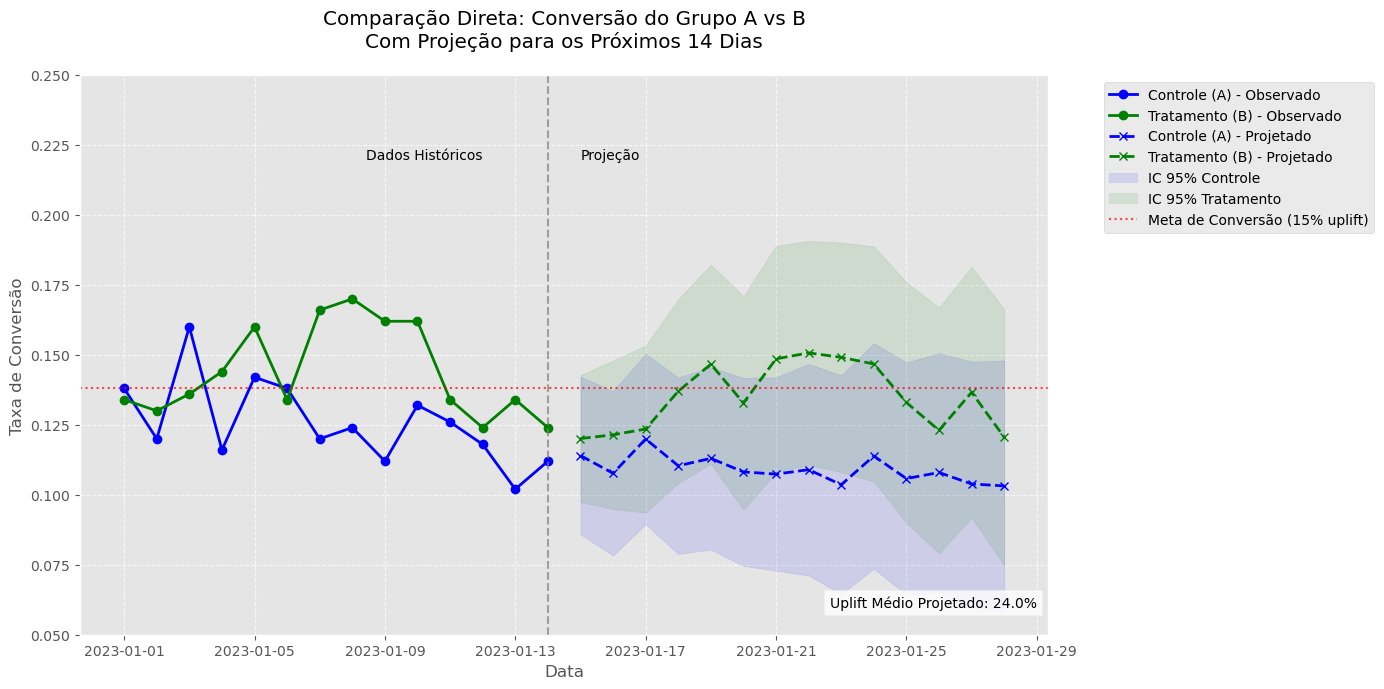

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import bernoulli
from datetime import datetime, timedelta

# Configurações iniciais
np.random.seed(42)
plt.style.use('ggplot')

## 1. Gerar dados sintéticos (mesmo código anterior)
n_users_per_group = 500
n_days = 14
dates = pd.date_range(start="2023-01-01", periods=n_days)

def generate_group_data(group_name, base_conversion, uplift=1.0):
    data = []
    for day in range(n_days):
        daily_effect = 0.02 * np.sin(day/3)
        true_conversion = base_conversion * uplift + daily_effect
        conversions = bernoulli.rvs(true_conversion, size=n_users_per_group)
        for user_id, conv in enumerate(conversions):
            data.append({
                'date': dates[day],
                'group': group_name,
                'user_id': f"{group_name}_{day}_{user_id}",
                'converted': conv
            })
    return data

control_data = generate_group_data('A', 0.12)
treatment_data = generate_group_data('B', 0.12, 1.15)
df = pd.DataFrame(control_data + treatment_data)
daily_stats = df.groupby(['date', 'group'])['converted'].mean().reset_index()
daily_stats.rename(columns={'converted': 'conversion_rate'}, inplace=True)

## 2. Modelagem e projeção (mesmo código anterior)
def forecast_conversion_rate(series, days_to_forecast=14):
    ts = series.set_index('date')['conversion_rate']
    try:
        model = SARIMAX(ts, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
        model_fit = model.fit(disp=False)
    except:
        model = ARIMA(ts, order=(1, 0, 1))
        model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=days_to_forecast)
    forecast_df = forecast.conf_int()
    forecast_df['forecast'] = forecast.predicted_mean
    return ts, forecast_df

control_series = daily_stats[daily_stats['group'] == 'A'].copy()
treatment_series = daily_stats[daily_stats['group'] == 'B'].copy()
days_to_forecast = 14
ts_control, forecast_control = forecast_conversion_rate(control_series, days_to_forecast)
ts_treatment, forecast_treatment = forecast_conversion_rate(treatment_series, days_to_forecast)

## 3. Gráfico único comparativo
plt.figure(figsize=(14, 7))

# Plotar dados observados
plt.plot(ts_control.index, ts_control.values, 
        label='Controle (A) - Observado', 
        color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(ts_treatment.index, ts_treatment.values, 
        label='Tratamento (B) - Observado', 
        color='green', marker='o', linestyle='-', linewidth=2)

# Plotar projeções
projected_dates = pd.date_range(start=dates[-1] + timedelta(days=1), periods=days_to_forecast)
plt.plot(projected_dates, forecast_control['forecast'], 
        label='Controle (A) - Projetado', 
        color='blue', marker='x', linestyle='--', linewidth=2)
plt.plot(projected_dates, forecast_treatment['forecast'], 
        label='Tratamento (B) - Projetado', 
        color='green', marker='x', linestyle='--', linewidth=2)

# Adicionar intervalos de confiança
plt.fill_between(projected_dates,
                forecast_control['lower conversion_rate'],
                forecast_control['upper conversion_rate'],
                color='blue', alpha=0.1, label='IC 95% Controle')
plt.fill_between(projected_dates,
                forecast_treatment['lower conversion_rate'],
                forecast_treatment['upper conversion_rate'],
                color='green', alpha=0.1, label='IC 95% Tratamento')

# Calcular e plotar uplift diário
observed_uplift = (ts_treatment - ts_control) / ts_control * 100
projected_uplift = (forecast_treatment['forecast'] - forecast_control['forecast']) / forecast_control['forecast'] * 100

# Adicionar linha de uplift esperado (15%)
plt.axhline(y=0.12*1.15, color='red', linestyle=':', 
           label='Meta de Conversão (15% uplift)', alpha=0.7)

# Adicionar linha vertical separando histórico e projeção
plt.axvline(x=dates[-1], color='gray', linestyle='--', alpha=0.7)
plt.text(dates[-1] - timedelta(days=2), 0.22, 'Dados Históricos', ha='right')
plt.text(dates[-1] + timedelta(days=1), 0.22, 'Projeção', ha='left')

# Configurações do gráfico
plt.title('Comparação Direta: Conversão do Grupo A vs B\nCom Projeção para os Próximos 14 Dias', pad=20)
plt.ylabel('Taxa de Conversão', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.ylim(0.05, 0.25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionar texto com uplift médio
plt.text(projected_dates[-1] + timedelta(days=1), 0.06,
        f'Uplift Médio Projetado: {np.mean(projected_uplift):.1f}%',
        ha='right', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\marco.aragon\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre


Análise com Dados Reais (14 dias)
Controle (A): 880/7000 = 0.1257 (12.57%)
Tratamento (B): 1007/7000 = 0.1439 (14.39%)
Uplift: 14.43%

Teste Z para proporções:
Z-statistic: 3.1431, p-value: 0.000836

Teste T (independente):
T-statistic: 3.1440, p-value: 0.001670

Conclusão:
Rejeitamos a hipótese nula - diferença estatisticamente significativa
O tratamento (B) performou melhor que o controle (A)

Intervalos de Confiança 95%:
Controle: [0.1179, 0.1335]
Tratamento: [0.1356, 0.1521]

Análise com Dados Projetados (14 dias futuros)
Controle (A): 927/7000 = 0.1324 (13.24%)
Tratamento (B): 958/7000 = 0.1369 (13.69%)
Uplift: 3.34%

Teste Z para proporções:
Z-statistic: 0.7676, p-value: 0.221376

Teste T (independente):
T-statistic: 0.7675, p-value: 0.442789

Conclusão:
Não rejeitamos a hipótese nula - diferença não estatisticamente significativa

Intervalos de Confiança 95%:
Controle: [0.1245, 0.1404]
Tratamento: [0.1288, 0.1449]

Análise com Dados Reais + Projetados (28 dias)
Controle (A): 18

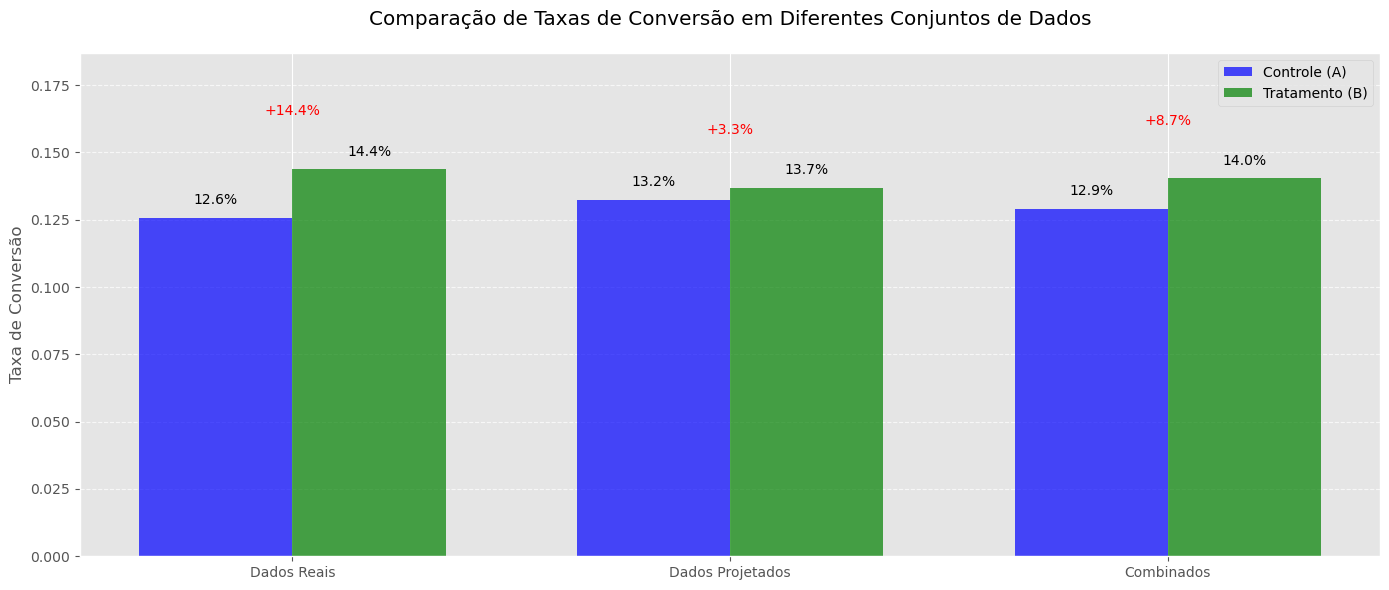

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import bernoulli, ttest_ind
from datetime import datetime, timedelta

# Configurações
np.random.seed(42)
plt.style.use('ggplot')

## 1. Gerar dados sintéticos (mesmo código anterior)
n_users_per_group = 500
n_days = 14
dates = pd.date_range(start="2023-01-01", periods=n_days)

def generate_group_data(group_name, base_conversion, uplift=1.0):
    data = []
    for day in range(n_days):
        daily_effect = 0.02 * np.sin(day/3)
        true_conversion = base_conversion * uplift + daily_effect
        conversions = bernoulli.rvs(true_conversion, size=n_users_per_group)
        data.extend([{
            'date': dates[day],
            'group': group_name,
            'user_id': f"{group_name}_{day}_{i}",
            'converted': conv
        } for i, conv in enumerate(conversions)])
    return data

control_data = generate_group_data('A', 0.12)
treatment_data = generate_group_data('B', 0.12, 1.15)
df = pd.DataFrame(control_data + treatment_data)

## 2. Modelagem e projeção
def forecast_conversion(group_data, days_to_forecast=14):
    daily = group_data.groupby('date')['converted'].agg(['sum', 'count'])
    ts = daily['sum'] / daily['count']
    
    try:
        model = ARIMA(ts, order=(1, 0, 1))
        model_fit = model.fit()
    except:
        model = ARIMA(ts, order=(1, 0, 0))
        model_fit = model.fit()
    
    forecast = model_fit.get_forecast(steps=days_to_forecast)
    forecast_mean = forecast.predicted_mean
    forecast_conf = forecast.conf_int()
    
    # Gerar dados sintéticos baseados na projeção
    projected_data = []
    for i, (date, conv_rate) in enumerate(zip(
        pd.date_range(start=dates[-1]+timedelta(days=1), periods=days_to_forecast),
        forecast_mean
    )):
        conversions = bernoulli.rvs(conv_rate, size=n_users_per_group)
        projected_data.extend([{
            'date': date,
            'group': group_data['group'].iloc[0],
            'user_id': f"{group_data['group'].iloc[0]}_proj_{i}_{j}",
            'converted': conv
        } for j, conv in enumerate(conversions)])
    
    return pd.DataFrame(projected_data), forecast_mean, forecast_conf

# Gerar projeções
df_proj_control, fc_control, fc_control_conf = forecast_conversion(df[df['group'] == 'A'])
df_proj_treatment, fc_treatment, fc_treatment_conf = forecast_conversion(df[df['group'] == 'B'])

# Combinar dados reais + projetados
df_combined = pd.concat([df, df_proj_control, df_proj_treatment])

## 3. Função para análise estatística
def perform_ab_test(data, title):
    # Preparar dados
    control = data[data['group'] == 'A']
    treatment = data[data['group'] == 'B']
    
    # Contagens
    n_control = len(control)
    n_treatment = len(treatment)
    conv_control = sum(control['converted'])
    conv_treatment = sum(treatment['converted'])
    
    # Taxas de conversão
    rate_control = conv_control / n_control
    rate_treatment = conv_treatment / n_treatment
    uplift = (rate_treatment - rate_control) / rate_control * 100
    
    # Teste Z para proporções
    zstat, pvalue = proportions_ztest(
        [conv_treatment, conv_control],
        [n_treatment, n_control],
        alternative='larger'
    )
    
    # Teste T (para comparação)
    tstat, tpvalue = ttest_ind(
        treatment['converted'],
        control['converted'],
        equal_var=False
    )
    
    # Resultados
    print(f"\n{title}")
    print("="*50)
    print(f"Controle (A): {conv_control}/{n_control} = {rate_control:.4f} ({rate_control*100:.2f}%)")
    print(f"Tratamento (B): {conv_treatment}/{n_treatment} = {rate_treatment:.4f} ({rate_treatment*100:.2f}%)")
    print(f"Uplift: {uplift:.2f}%")
    print("\nTeste Z para proporções:")
    print(f"Z-statistic: {zstat:.4f}, p-value: {pvalue:.6f}")
    print("\nTeste T (independente):")
    print(f"T-statistic: {tstat:.4f}, p-value: {tpvalue:.6f}")
    
    # Interpretação
    print("\nConclusão:")
    if pvalue < 0.05:
        print("Rejeitamos a hipótese nula - diferença estatisticamente significativa")
        if rate_treatment > rate_control:
            print("O tratamento (B) performou melhor que o controle (A)")
        else:
            print("O controle (A) performou melhor que o tratamento (B)")
    else:
        print("Não rejeitamos a hipótese nula - diferença não estatisticamente significativa")
    
    print("\nIntervalos de Confiança 95%:")
    print(f"Controle: [{rate_control - 1.96*np.sqrt(rate_control*(1-rate_control)/n_control):.4f}, {rate_control + 1.96*np.sqrt(rate_control*(1-rate_control)/n_control):.4f}]")
    print(f"Tratamento: [{rate_treatment - 1.96*np.sqrt(rate_treatment*(1-rate_treatment)/n_treatment):.4f}, {rate_treatment + 1.96*np.sqrt(rate_treatment*(1-rate_treatment)/n_treatment):.4f}]")

## 4. Executar análises
# A) Apenas dados reais
perform_ab_test(df, "Análise com Dados Reais (14 dias)")

# B) Apenas dados projetados
perform_ab_test(pd.concat([df_proj_control, df_proj_treatment]), "Análise com Dados Projetados (14 dias futuros)")

# C) Dados reais + projetados
perform_ab_test(df_combined, "Análise com Dados Reais + Projetados (28 dias)")

## 5. Visualização dos resultados
plt.figure(figsize=(14, 6))

# Dados para o gráfico
categories = ['Dados Reais', 'Dados Projetados', 'Combinados']
control_rates = [
    sum(df[df['group'] == 'A']['converted']) / len(df[df['group'] == 'A']),
    sum(df_proj_control['converted']) / len(df_proj_control),
    sum(df_combined[df_combined['group'] == 'A']['converted']) / len(df_combined[df_combined['group'] == 'A'])
]
treatment_rates = [
    sum(df[df['group'] == 'B']['converted']) / len(df[df['group'] == 'B']),
    sum(df_proj_treatment['converted']) / len(df_proj_treatment),
    sum(df_combined[df_combined['group'] == 'B']['converted']) / len(df_combined[df_combined['group'] == 'B'])
]

# Barras para controle e tratamento
bar_width = 0.35
x = np.arange(len(categories))
plt.bar(x - bar_width/2, control_rates, bar_width, label='Controle (A)', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, treatment_rates, bar_width, label='Tratamento (B)', color='green', alpha=0.7)

# Adicionar valores e uplift
for i, (cr, tr) in enumerate(zip(control_rates, treatment_rates)):
    plt.text(i - bar_width/2, cr + 0.005, f"{cr*100:.1f}%", ha='center')
    plt.text(i + bar_width/2, tr + 0.005, f"{tr*100:.1f}%", ha='center')
    uplift = (tr - cr)/cr * 100
    plt.text(i, max(cr, tr) + 0.02, f"+{uplift:.1f}%", ha='center', fontsize=10, color='red')

# Configurações do gráfico
plt.title('Comparação de Taxas de Conversão em Diferentes Conjuntos de Dados', pad=20)
plt.ylabel('Taxa de Conversão')
plt.xticks(x, categories)
plt.ylim(0, max(treatment_rates)*1.3)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()